In [4]:
from tidynamics import msd, acf

from scipy.optimize import curve_fit

import numpy as np

import h5py

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

matplotlib.rcParams['xtick.labelsize']=20
matplotlib.rcParams['ytick.labelsize']=20
matplotlib.rcParams['font.size']=25
matplotlib.rcParams['legend.fontsize']=20
matplotlib.rcParams['axes.labelsize']=20
matplotlib.rcParams['text.latex.preamble']=[r'\usepackage{bm}', r'\usepackage{textgreek}', r'\usepackage{sfmath}', r'\usepackage{siunitx}', r'\sisetup{per-mode=reciprocal}    ', r'\DeclareSIUnit\Molar{M}']
matplotlib.rc('text',usetex=True)

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.


In [5]:
job_names = ['50591797', '50593010', '50593011']
data_dir = '/Volumes/_work/genius/scratch/'

Shear velocity: 0.05
Shear rate: 0.0033471647504108473
Diffusion coefficient directly from MSD in shearing dir: 0.30353360347829744
Diffusion coefficient in the vorticity direction 0.299301531347424
Ratio: 0.9860573192477647
Shear velocity: 0.1
Shear rate: 0.006694329500821695
Diffusion coefficient directly from MSD in shearing dir: 0.2968316011096192
Diffusion coefficient in the vorticity direction 0.3043115722490469
Ratio: 1.02519937604846
Shear velocity: 0.25
Shear rate: 0.016735823752054235
Diffusion coefficient directly from MSD in shearing dir: 0.29642954512039127
Diffusion coefficient in the vorticity direction 0.2992887256470425
Ratio: 1.0096453966000252
Shear velocity: 0.5
Shear rate: 0.03347164750410847
Diffusion coefficient directly from MSD in shearing dir: 0.3069160128679129
Diffusion coefficient in the vorticity direction 0.3033187260531246
Ratio: 0.9882792468819915
Shear velocity: 0.75
Shear rate: 0.05020747125616271
Diffusion coefficient directly from MSD in shearing di

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Diffusion coefficient directly from MSD in shearing dir: 0.30100881992730566
Diffusion coefficient in the vorticity direction 0.29674731452382874
Ratio: 0.9858425895809096
Shear velocity: 0.1
Shear rate: 0.006694329500821695
Diffusion coefficient directly from MSD in shearing dir: 0.3030824854624184
Diffusion coefficient in the vorticity direction 0.2946935460284069
Ratio: 0.9723212662017987
Shear velocity: 0.25
Shear rate: 0.016735823752054235
Diffusion coefficient directly from MSD in shearing dir: 0.29254623402964475
Diffusion coefficient in the vorticity direction 0.29736392236347
Ratio: 1.0164681263110604
Shear velocity: 0.5
Shear rate: 0.03347164750410847
Diffusion coefficient directly from MSD in shearing dir: 0.30279672301665894
Diffusion coefficient in the vorticity direction 0.2962545755248784
Ratio: 0.9783942592687153
Shear velocity: 0.75
Shear rate: 0.05020747125616271
Diffusion coefficient directly from MSD in shearing dir: 0.30061153485670117
Diffusion coefficient in the 

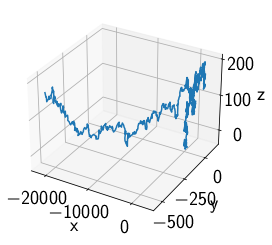

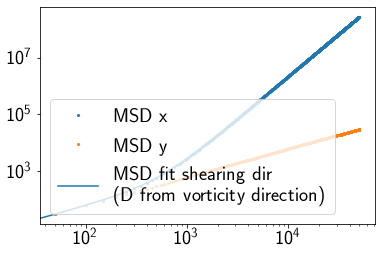

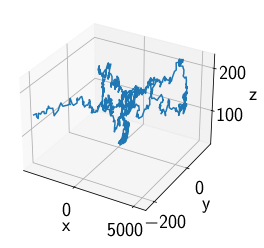

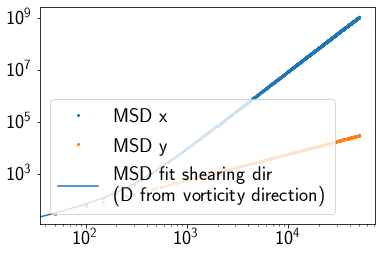

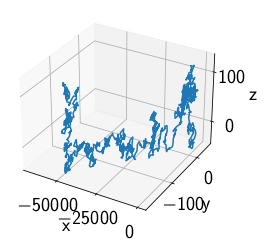

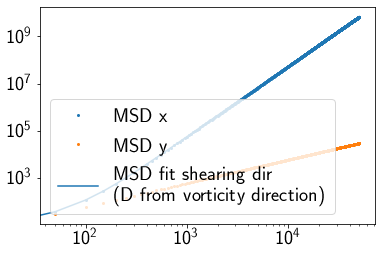

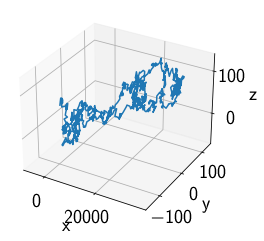

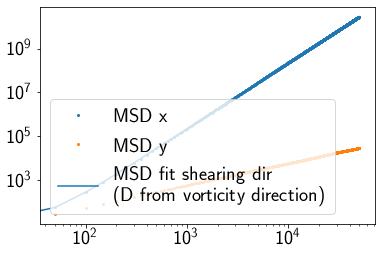

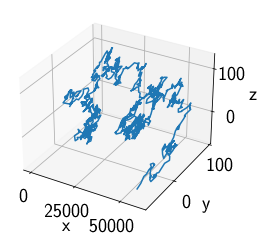

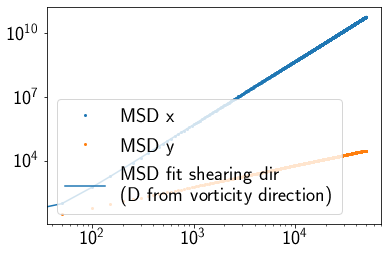

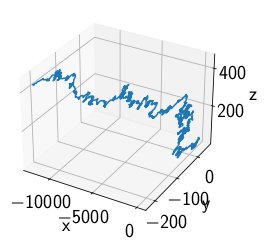

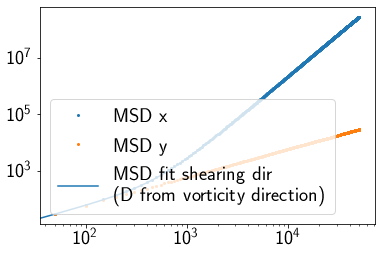

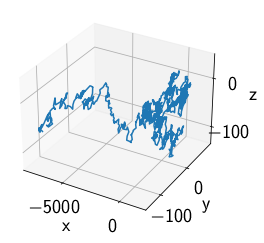

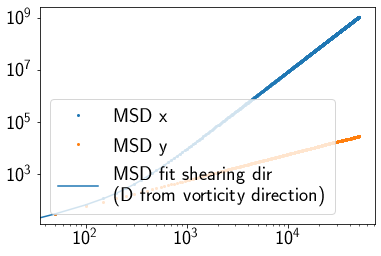

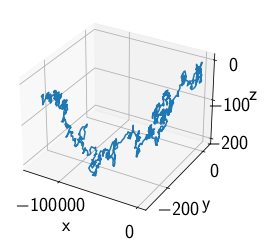

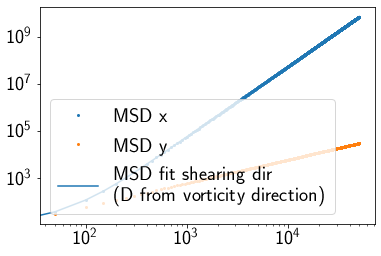

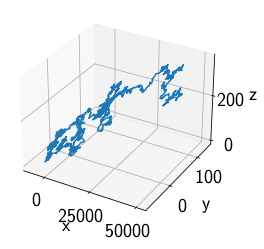

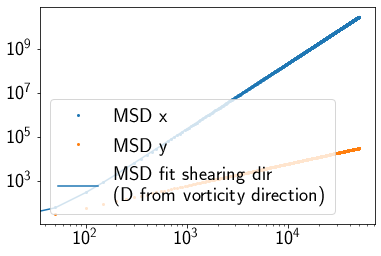

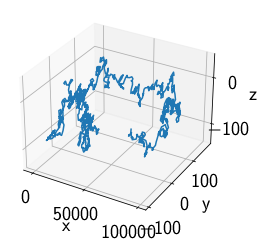

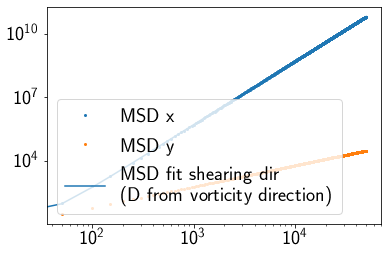

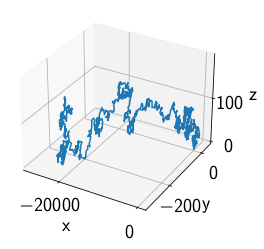

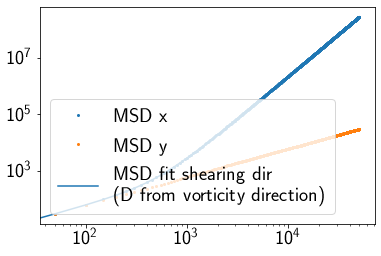

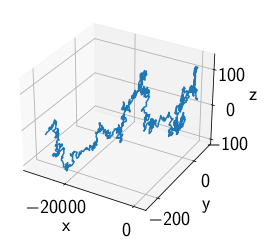

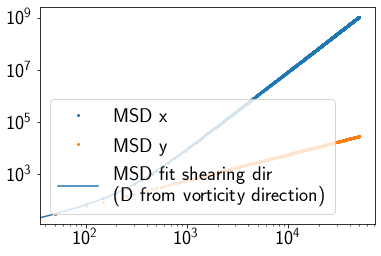

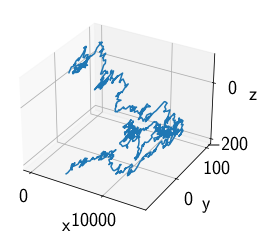

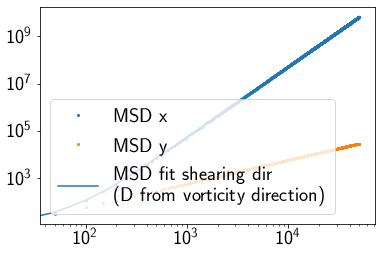

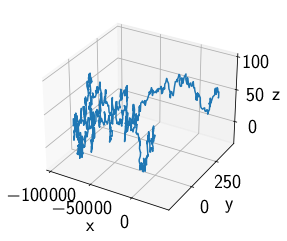

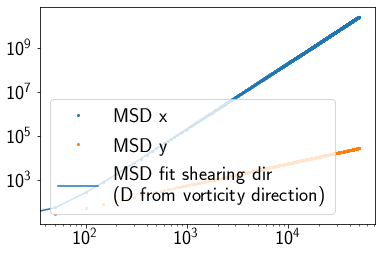

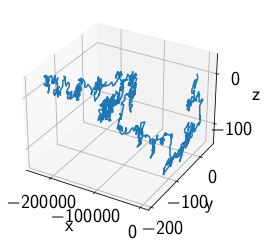

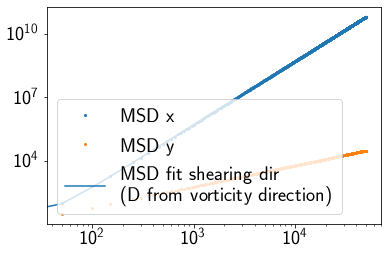

In [6]:
def fit_shear(time, D):
    return 2.0 * D * time * (1+ 1./3. * (shear_rate * time) ** 2.0)

def fit(time, D):
    return 2.0 * D * time

cutoff = 1000
particles = 10000

msd_x = np.empty([5,1000])
msd_z = np.empty([5,1000])
fit_params = np.empty([5,3])
fit_params_shear = np.empty([5,3])

run = 0

for job_name in job_names:
    for i in range(5):
        j = i+1

        with open('../parameter_files/params_dpd_vel.csv') as f:
            line = f.readlines()[j]
            line = line.split(',')
            
        shear_vel = float(line[0]) / 2.0
    
        print("Shear velocity:", shear_vel)
    
        h5file = h5py.File(data_dir + 'le_traj_' + job_name + '[' + str(j) +']/trajectory.h5', 'r')

        r = h5file['particles/atoms/position/value'][:-cutoff]
        vel = h5file['particles/atoms/velocity/value'][:-cutoff]
        image = h5file['particles/atoms/image/value'][:-cutoff]
        le_offset = h5file['particles/atoms/lees_edwards_offset/value'][:-cutoff]
        edges = h5file['particles/atoms/box/edges/'][:]
        r_time = h5file['particles/atoms/position/time'][:-cutoff]
    
        time = r_time-r_time[0]

        shear_rate = shear_vel / edges[1]
        print("Shear rate:", shear_rate)
    
        # Get trajectory of all particles and unwrap them
        # Add the LE offset

        pos = r + image*edges[None,None,:]
        pos[:,:,0] -= le_offset

        selected_part = np.random.randint(0, particles)
    
        x_traj_single = pos[:, selected_part, 0]
        y_traj_single = pos[:, selected_part, 1]
        z_traj_single = pos[:, selected_part, 2]

        x_traj_all = pos[:, :, 0]
        y_traj_all = pos[:, :, 1]
        z_traj_all = pos[:, :, 2]
    
        plt.figure()
        ax = plt.axes(projection = '3d')
        ax.plot(x_traj_single, y_traj_single, z_traj_single)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')

        msd_x_all = np.empty_like(x_traj_all)
        msd_y_all = np.empty_like(y_traj_all)
        msd_z_all = np.empty_like(z_traj_all)

        for k in range(particles):
            for l in range(len(x_traj_single)):
                msd_x_all[l,k] = (x_traj_all[l,k] - x_traj_all[0,k] -  time[l] * shear_vel * (y_traj_all[0,k] / edges[1] - 0.5)) ** 2.
                msd_y_all[l,k] = (y_traj_all[l,k] - y_traj_all[0,k]) ** 2.
                msd_z_all[l,k] = (z_traj_all[l,k] - z_traj_all[0,k]) ** 2.

        msd_x_mean = np.mean(msd_x_all, axis=1)
        msd_y_mean = np.mean(msd_y_all, axis=1)
        msd_z_mean = np.mean(msd_z_all, axis=1)
    
        msd_x[i,:] = msd_x_mean
        msd_z[i,:] = msd_z_mean

        opt3, cov3 = curve_fit(fit_shear, time, msd_x_mean)
        print("Diffusion coefficient directly from MSD in shearing dir:", opt3[0])
        opt4, cov4 = curve_fit(fit, time, msd_z_mean)
        print("Diffusion coefficient in the vorticity direction", opt4[0])
    
        print("Ratio:", opt4[0]/opt3[0])
    
        fit_params[i, run] = opt3
        fit_params_shear[i, run] = opt4

        plt.figure()
        plt.plot(time, msd_x_mean, 'o', color="tab:blue", markersize='2', label="MSD x")
        plt.plot(time, msd_z_mean, 'o', color="tab:orange", markersize='2', label="MSD y")

        plt.plot(time, fit_shear(time, *opt4), color='tab:blue', label = "MSD fit shearing dir \n(D from vorticity direction)")
        plt.legend()
        plt.loglog()
        
    run += 1

plt.show()

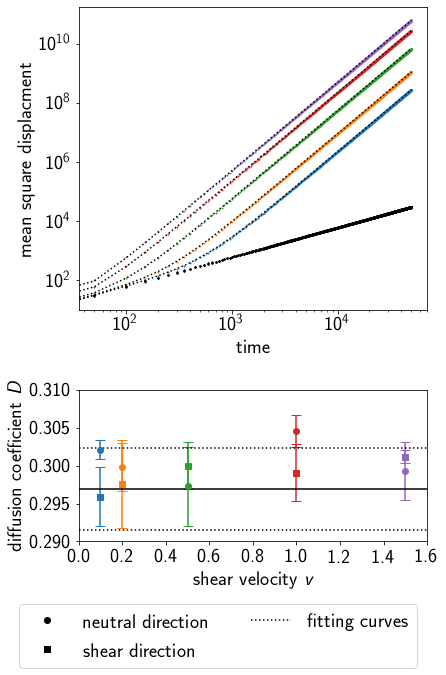

In [7]:
fig, axs = plt.subplots(2,1, figsize=(2*3.375,3*3.375), gridspec_kw={'height_ratios': [2, 1]})
colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

for i in range(5):
    
    with open('../parameter_files/params_dpd_vel.csv') as f:
        line = f.readlines()[i+1]
        line = line.split(',')
        
    shear_vel = float(line[0]) / 2.0
    shear_rate = shear_vel / edges[1]
    
    axs[0].plot(time, msd_x[i,:], 'o', markersize='1', color=colors[i])
    axs[0].plot(time, fit_shear(time, fit_params_shear[i,0]), 'k:')
    axs[0].plot(time, msd_z[i,:], 'ko', markersize='1')
    
    axs[1].errorbar(2.0*shear_vel, np.mean(fit_params[i,:]), yerr=np.std(fit_params[i,:], ddof=1), marker='o', color=colors[i], capsize = 5)
    axs[1].errorbar(2.0*shear_vel, np.mean(fit_params_shear[i,:]), yerr=np.std(fit_params_shear[i,:], ddof=1), marker='s', color=colors[i], capsize = 5)
    
axs[0].loglog()

axs[0].set_xlabel('time')
axs[0].set_ylabel('mean square displacment')


axs[1].plot([],[], 'ko', label = 'neutral direction')
axs[1].plot([],[], 'ks', label = 'shear direction')
axs[1].plot([],[], 'k:', label = 'fitting curves')
axs[1].legend(loc='lower center', bbox_to_anchor=(0.4, -.9), ncol=2)

axs[1].set_xlim(0.0,1.6)
axs[1].locator_params(axis='x', nbins=8)
axs[1].set_ylabel('diffusion coefficient $D$')

axs[1].set_ylim(0.29,0.31)
axs[1].locator_params(axis='y', nbins=5)

axs[1].axhline(y=0.29689698, color='k')
axs[1].axhline(y=0.29689698 + 0.00543089, c='k', linestyle = ':')
axs[1].axhline(y=0.29689698 - 0.00543089, c='k', linestyle = ':')
axs[1].set_xlabel('shear velocity $v$')


plt.tight_layout()
#plt.savefig("adv_diff_contishear.pdf")